In [ ]:
%pip install pandas
%pip install matplotlib

In [ ]:
import time
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 100)

In [14]:
start = time.time()

def find_Nucleosides_From_MS2(high_res_ms2_file1, intens_cutoff1, ppm_tolerance1):
    ####----------Input: mgf file, ms2 intensity cutoff value (%), mass tolerance (ppm)
    ####----------Output: two dataframes, dataframe1 contains raw candidate nucleoside MS2 spectra, dataframe2 contains summarized nucleosides
    
    #-----Open mgf file
    with open(f'{high_res_ms2_file1}.mgf', 'r') as f:
        file1 = f.readlines()
    
    #-----MS2 relative intensity low % cut-off
    #--ruling out low intensity peaks that might be construed as coincidental noise
    intensity_percent_cutoff = intens_cutoff1
        #% value

    #-----Neutral loss masses and tolerance settings
    #--stratified by charge state; since nucleosides are likely to be +1 and +2 charges, we won't consider ions of greater charge states
    neutral_loss_mass_list_charge1 = [116.0473]
    neutral_loss_mass_list_charge2 = [58.0237, 117.0552, 139.0371]
        #116.0473 = dRibose (+1; H+ or Na+; -H+ or -Na+)
        #58.0237 = dRibose(+2; 2H+ or 2Na+; -2H+ or -2Na+)
        #117.0552 = dRibose (+2; H+Na+; -H+)
        #139.0371 = dRibose (+2; H+Na+; -Na+)

    #-----Mass tolerance setting
    #---this will be spectrometer and setting dependent; here we have lock-mass Orbitrap data collected at 100,000 resolution
    mass_tolerance1 = ppm_tolerance1
        #in ppm

    #-----Declare variables
    #---Temporary variables
    temp_scan_num = 0
    temp_retention = 0
    temp_precursor = 0
    temp_precursor_intensity = 0
    temp_charge = 0
    temp_max_ms2_intensity = 0
    temp_ms2_intensity_list1 = []
    temp_ms2_mass = 0
    temp_ms2_intensity = 0
    temp_candidate_ms2_mass_list1 = []
    temp_candidate_ms2_intensity_list1 = []
    temp_tuple1 = ()
    #---Persisent variables
    candidate_list_of_tuples = []

    #-----Collect spectrum data iterating through mgf file one MS2 spectrum at a time
    #---ms2 masses that pass filter are stored as tuples in 'candidate_list_of_tuples list variable'

    for line1 in file1:
        if 'BEGIN IONS' in line1:
            temp_scan_num = 0
            temp_retention = 0
            temp_precursor = 0
            temp_precursor_intensity = 0
            temp_charge = 0
        elif 'TITLE=' in line1:
            line2 = line1.split(' ')
            for item1 in line2:
                if 'scan=' in item1:
                    temp_scan_num = int(item1.split('scan=')[1].split('"')[0])
        elif 'RTINSECONDS=' in line1:
            temp_retention = float(line1.split('=')[1].replace('\n', ''))
        elif 'PEPMASS=' in line1:
            temp_precursor = float(line1.split(' ')[0].split('=')[1])
            temp_precursor_intensity = float(line1.split(' ')[1].replace('\n', ''))
        elif 'CHARGE=' in line1:
            temp_charge = int(line1.split('=')[1].split('+')[0])
        elif 'END ION' in line1:
            try:
                temp_max_ms2_intensity = max(temp_ms2_intensity_list1)
                temp_ms2_intensity_list1 = []
                for count, item1 in enumerate(temp_candidate_ms2_mass_list1):
                    temp_tuple1 = (temp_scan_num, temp_retention, temp_precursor, temp_precursor_intensity, temp_charge, item1, temp_candidate_ms2_intensity_list1[count], temp_max_ms2_intensity)
                    candidate_list_of_tuples.append(temp_tuple1)
                temp_tuple1 = ()
                temp_candidate_ms2_mass_list1 = []
                temp_candidate_ms2_intensity_list1 = []
            except:
                pass
        else:
            if temp_charge == 1:
                try:
                    temp_ms2_mass = float(line1.split(' ')[0])
                    temp_ms2_intensity = float(line1.split(' ')[1].replace('\n', ''))
                    temp_ms2_intensity_list1.append(temp_ms2_intensity)
                    for item1 in neutral_loss_mass_list_charge1:
                        if (abs(round(abs((temp_ms2_mass - temp_precursor)), 4) - item1)/temp_ms2_mass)*1000000 < mass_tolerance1 :
                            temp_candidate_ms2_mass_list1.append(temp_ms2_mass)
                            temp_candidate_ms2_intensity_list1.append(temp_ms2_intensity)
                except:
                    pass
            if temp_charge == 2:
                try:
                    temp_ms2_mass = float(line1.split(' ')[0])
                    temp_ms2_intensity = float(line1.split(' ')[1].replace('\n', ''))
                    temp_ms2_intensity_list1.append(temp_ms2_intensity)
                    for item1 in neutral_loss_mass_list_charge2:
                        if (abs(round(abs((temp_ms2_mass - temp_precursor)), 4) - item1)/temp_ms2_mass)*1000000 < mass_tolerance1 :
                            temp_candidate_ms2_mass_list1.append(temp_ms2_mass)
                            temp_candidate_ms2_intensity_list1.append(temp_ms2_intensity)
                except:
                    pass

    #-----Create dataframe from tuples
    #---name columns accordingly
    df1 = pd.DataFrame(candidate_list_of_tuples, columns=['scan', 'retention_sec', 'precursor_mz', 'precursor_intensity', 'charge', 'ms2_mz', 'ms2_intensity', 'ms2_max_intensity'])

    #---Calculate ms2 peak relative intensities and insert in new column
    ms2_relative_intensity_list = []
    for row1 in df1.itertuples():
        temp_var1 = round(((row1.ms2_intensity/row1.ms2_max_intensity)*100), 1)
        ms2_relative_intensity_list.append(temp_var1)
    df1['ms2_relative_intensity'] = ms2_relative_intensity_list

    #---select only rows with relative intensities above user-defined cut-off value
    df2 = df1.loc[df1['ms2_relative_intensity'] > intensity_percent_cutoff].copy()

    #---create column with rounded precursor values for grouping
    rounded_precursor_list = []
    for row1 in df2.itertuples():
        temp_var1 = round(row1.precursor_mz, 3)
        rounded_precursor_list.append(temp_var1)
    df2['rounded_precursor'] = rounded_precursor_list

    #-----Create new dataframe containing mean aggregated values (simplified list of potential nucleosides)
    df3 = df2.groupby('rounded_precursor').mean()
    df3 = df3[['precursor_mz', 'precursor_intensity', 'charge', 'ms2_mz', 'ms2_intensity', 'ms2_max_intensity', 'ms2_relative_intensity']]
    df3['charge'] = df3['charge'].astype(int)
    df3['ms2_relative_intensity'] = df3['ms2_relative_intensity'].round(1)
    
    #-----Add file column to denote file or origin
    df1['filename'] = high_res_ms2_file1
    df2['filename'] = high_res_ms2_file1
    df3['filename'] = high_res_ms2_file1

    #-----Dataframe key:
    #df1: raw dataframe
    #df2: dataframe with selected values (above relative intensity threshold)
    #df3: dataframe containing aggregate precursor values (simplified)
    
    return df1, df3

def assign_Nucleotides_to_Masses(query_mass1, query_tol1):
    ####----------Input: Nucleotide mass (query_mass1) and ppm tolerance (query_tol1)
    ####----------Output: list of strings describing outcome of mass query (nucleotide base or unknown)
    #------Create reference lists
    base_tuple_list = [('adenine', 135.05450), ('guanine', 151.04941), ('thymine', 126.04293), 
                       ('uracil', 112.02728), ('hm_uracil', 142.03784), ('hmg_uracil', 304.09067), 
                       ('cytosine', 111.04326), ('hm_cytosine', 141.05383), ('hmg_cytosine', 303.10665)]
    charged_adduct_tuple_list = [('+H', 1.00783, 1), ('+Na', 22.98977, 1), ('+K', 38.96371, 1), ('+Ca', 39.96259, 2), ('+Mg,', 23.98504, 2), 
                                 ('+2H', 2.01565, 2), ('+2Na', 45.97954, 2), ('+2K', 77.92741, 2), ('+H+Na', 23.99759, 2), ('+H+K', 39.97153, 2), ('+Na+K', 61.95348, 2)]
    neutral_adduct_tuple_list = [('', 0.0), ('+NH3', 17.02655), ('+CH3COOH', 58.00548), ('+H2O', 18.01056), ('+TFA', 113.99286), ('+MeCN', 41.02655), ('+MeOH', 32.02621), ('+PrOH', 60.05751)]
    #------Declare variables
    list_of_hits1 = []
    #------Iterate through mass combinations
    for item1 in charged_adduct_tuple_list:
        for item2 in neutral_adduct_tuple_list:
            for item3 in base_tuple_list:
                if (abs(query_mass1 - ((item3[1] + item2[1] + item1[1])/item1[2]))/query_mass1)*1000000 < query_tol1:
                    temp_identity1 = str('[' + item3[0] + item2[0] + item1[0] + ']')
                    list_of_hits1.append(temp_identity1)
    return list_of_hits1
    

end = time.time()
print(end-start)

0.0


In [18]:
start = time.time()

#------mgf files to read-in
filename_list = ['ORB59709', 'ORB59710', 'ORB59711']

#------create empty dataframes
combined_raw_results = pd.DataFrame()
combined_summary_results = pd.DataFrame()

#------load up empty dataframes with nucleoside candidates
for item1 in filename_list:
    df_A, df_B = find_Nucleosides_From_MS2(item1, 5, 10)
    combined_raw_results = pd.concat([combined_raw_results, df_A])
    combined_summary_results = pd.concat([combined_summary_results, df_B])

#------assign identities to nucleoside candidates (when possible)
identity_column1 = []

for row1 in combined_summary_results.itertuples():
    temp_list2 = assign_Nucleotides_to_Masses(row1.ms2_mz, 20)
    identity_column1.append(temp_list2)

combined_summary_results['candidate_ID'] = identity_column1

    

end = time.time()
print(end-start)

1.8267278671264648


In [19]:
combined_raw_results

,scan,retention_sec,precursor_mz,precursor_intensity,charge,ms2_mz,ms2_intensity,ms2_max_intensity,ms2_relative_intensity,filename
0,35,93.9185,250.079758,1.476111e+06,1,134.031876,2.773924e+03,4.864856e+03,57.0,ORB59709
1,38,102.7485,287.146179,4.148803e+05,1,171.098618,1.177274e+02,3.446895e+03,3.4,ORB59709
2,41,111.0570,281.074341,1.776593e+07,1,165.026749,1.123107e+06,1.123107e+06,100.0,ORB59709
3,41,111.0570,281.074341,1.776593e+07,1,165.028030,8.480890e+03,1.123107e+06,0.8,ORB59709
4,44,118.5086,541.135620,1.805165e+06,1,425.088135,1.842402e+04,4.285788e+04,43.0,ORB59709
...,...,...,...,...,...,...,...,...,...,...
49,297,819.6991,268.104034,1.541257e+06,1,152.056000,3.109765e+02,9.388175e+04,0.3,ORB59711
50,322,888.2197,268.104065,1.554071e+06,1,152.055984,2.000855e+02,9.800879e+04,0.2,ORB59711
51,335,924.8070,252.109055,2.275147e+05,1,136.060440,2.187531e+02,1.647835e+04,1.3,ORB59711
52,335,924.8070,252.109055,2.275147e+05,1,136.061508,1.647835e+04,1.647835e+04,100.0,ORB59711


In [20]:
combined_summary_results

,precursor_mz,precursor_intensity,charge,ms2_mz,ms2_intensity,ms2_max_intensity,ms2_relative_intensity,filename,candidate_ID
rounded_precursor,,,,,,,,,
250.080,250.079758,1.476111e+06,1,134.031876,2.773924e+03,4.864856e+03,57.0,ORB59709,[[cytosine+Na]]
252.109,252.109013,1.192258e+06,1,136.061539,3.174116e+05,3.206475e+05,86.3,ORB59709,[[adenine+H]]
268.104,268.103973,3.785444e+05,1,152.056381,1.888525e+04,1.888525e+04,100.0,ORB59709,[[guanine+H]]
274.091,274.091064,1.847553e+06,1,158.043526,7.183229e+02,4.187823e+03,17.2,ORB59709,[[adenine+Na]]
281.074,281.074341,1.787950e+07,1,165.026817,5.911229e+05,5.911229e+05,100.0,ORB59709,[[hm_uracil+Na]]
290.086,290.085968,5.095263e+05,1,174.038406,6.620384e+04,6.661305e+04,90.0,ORB59709,[[guanine+Na]]
541.136,541.135620,1.805165e+06,1,425.088135,1.842402e+04,4.285788e+04,43.0,ORB59709,[]
243.098,243.097610,8.067196e+05,1,127.049789,4.952792e+03,7.959023e+03,62.2,ORB59710,[[thymine+H]]
252.109,252.109027,3.523865e+06,1,136.061558,3.378851e+05,3.414013e+05,89.2,ORB59710,[[adenine+H]]


0.07585000991821289


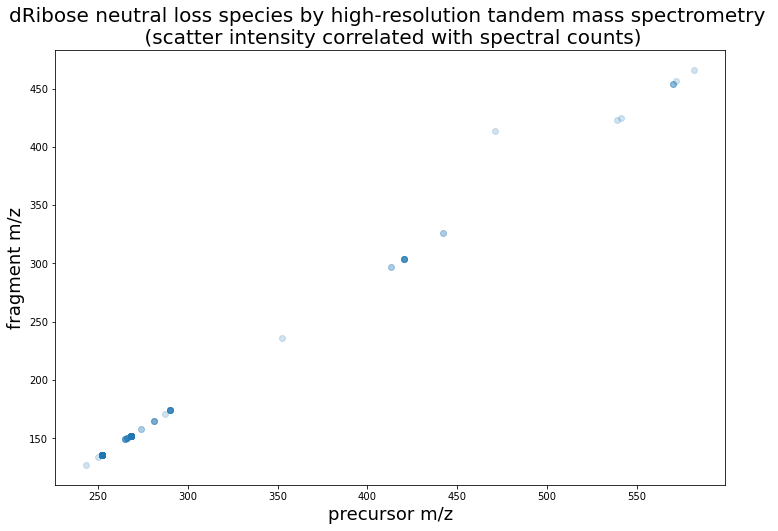

In [21]:
start = time.time()

#----------Scatter plot
plt.subplots(figsize=(12,8))
plt.scatter(combined_raw_results['precursor_mz'], combined_raw_results['ms2_mz'], alpha=0.2)
plt.xlabel('precursor m/z', size=18)
plt.ylabel('fragment m/z', size=18)
plt.title('dRibose neutral loss species by high-resolution tandem mass spectrometry \n (scatter intensity correlated with spectral counts)', size=20)
plt.savefig('dRibose_neutral_loss_scatter.jpg')

end = time.time()
print(end-start)

In [22]:
combined_raw_results.to_csv('dRibose_neutral_loss_combined_raw_results.csv', index=False)
combined_summary_results.to_csv('dRibose_neutral_loss_summary_results.csv', index=False)